# Image classification with Vanilla CNN architecture
In this nothbook, an attempt was made to build an  image classifer with classic vanilla CNN architectue on standard CIFAR-10 dataset. Tensorflow and keras libraries were used to construct the model and traied model with a kaggle gpu for rapid training. 
## Introduction:
The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images.This is a classification problem with 10 classes(muti-label    classification). We can take a view on this image for more comprehension of the dataset.

This image taken from the CIFAR repository.
(https://www.cs.toronto.edu/~kriz/cifar.html). I have loaded this dataset from keras datasets for this classification problem.

## Loading and Preprocessing data: 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

import tensorflow as tf
from keras.datasets import cifar10
import numpy as np
import pandas as pd 


/kaggle/input/cifar10-image-recognition/train.npy
/kaggle/input/cifar10-image-recognition/trainLabels.csv
/kaggle/input/cifar10-image-recognition/sampleSubmission.csv
/kaggle/input/cifar10-image-recognition/test.npy
/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10/cifar-10-batches-py/test_batch
/kaggle/input/cifar10

With above piece of code all the required libraries were imported for dataset loading and preprocessing.

In [2]:
# loading dateset
(x_train, y_train),(x_test,y_test) = cifar10.load_data() 

170500096/170498071 [==============================] - 11s 0us/step


In [3]:
# Checking loaded data 
print('Total number of Images in the Dataset:', len(x_train) + len(x_test))
print('Number of train images:', len(x_train))
print('Number of test images:', len(x_test))
print('Shape of training dataset:',x_train.shape)
print('Shape of testing dataset:',x_test.shape)
      

Total number of Images in the Dataset: 60000
Number of train images: 50000
Number of test images: 10000
Shape of training dataset: (50000, 32, 32, 3)
Shape of testing dataset: (10000, 32, 32, 3)


All right! Both the training and testing sets are ready for preprocessing. 
Before procceding furthur lets have a look at images from traing set. 
This image shows various classes in the dataset.

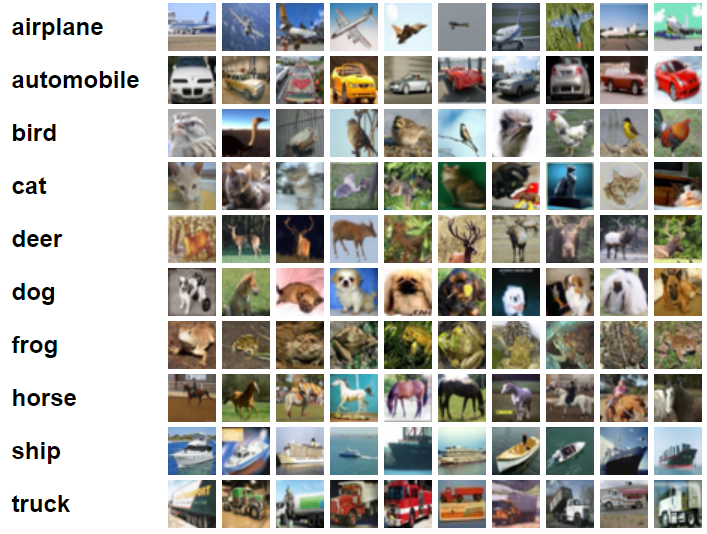


Sneak peaking into the traing set with this piece of code given below. 

In [4]:
# This piece of code shows a random images and labels for given set of inputs 

def showImages(num_row,num_col,X,Y):
    import matplotlib.pyplot as plt
    %matplotlib inline

    from sklearn.utils import shuffle
    (X_rand, Y_rand) = shuffle(X, Y)
    
    fig, axes = plt.subplots(num_row,num_col,figsize = (12,12))
    axes = axes.ravel()
    for i in range(0, num_row*num_col):
        axes[i].imshow(X_rand[i])
        axes[i].set_title("{}".format(labels[Y_rand.item(i)]))
        axes[i].axis('off')
        plt.subplots_adjust(wspace =1)
        
    return
    

In this dataset, total 10 classes are presents whose labels are taken as an array. This categoical classes are maped with numeric label in the dataset. labels array is going tobe useful for mapping y labels with there classes.

In [5]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

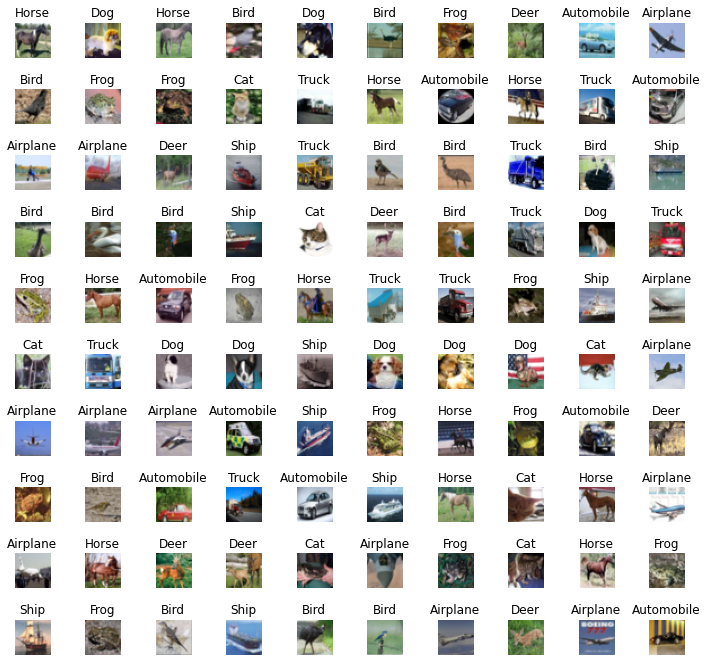

In [6]:
num_row = 10
num_col = 10
showImages(num_row,num_col,X =x_train,Y = y_train)


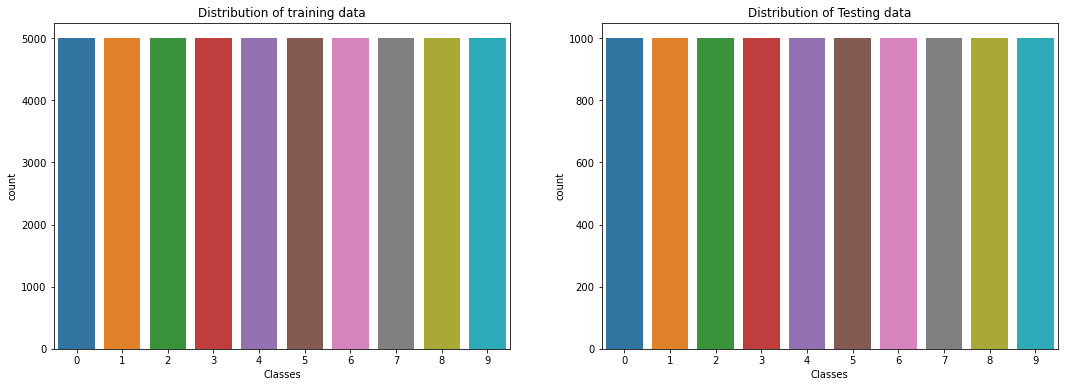

In [7]:
# Data visulization with seaborn  
# class count in train and test data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


figure, axis = plt.subplots( 1, 2 , figsize = (18,6))
sns.countplot(y_train.ravel(),ax = axis[0])
axis[0].set_title('Distribution of training data')
axis[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axis[1])
axis[1].set_title('Distribution of Testing data')
axis[1].set_xlabel('Classes')
plt.show()

#### Preprocessing data:
Now we have to prepare the data for fiting into the convoultional neural network. First step is to convert the data's data type to float32 and second have to normailize it by dividing pixel value of 255. later,implement one hot encoding to y labels to get a (m, class) array. m - is number of images 

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/ 255
x_test = x_test/255


In [9]:
#keras.utils.to_cotegorical(y, num_of_classes) convert the label 
#data into (m, num_of class) array from (m, 1) input 
import keras

y_train_one_hot = keras.utils.to_categorical(y_train, 10) #as classes = 10
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

In [10]:
print('The one hot label is: ', y_train_one_hot[1])
print(y_train_one_hot.shape)

The one hot label is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(50000, 10)


## Building Vanila CNN architecure 

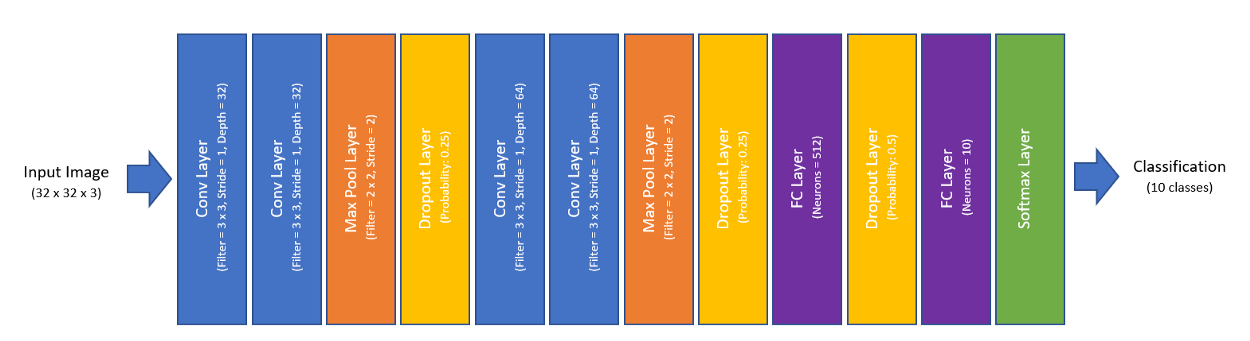

Above figure gives the details of the architecure we are building here. Input image is of (32 x 32 x 3) and output is a (1,10) array for single image. Network consts of two blocks of 2 conv_layers followed by maxPool_layer, and dropout_layer. After, that ouput is flattened out and passed through dropout layer followed by fully connected layer with sigmoid activation. Relu activation is used in all convlayers except in the last output layer. let's began the coding with importing libraries required.


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [12]:
#Building model computational graph
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (32,32,3)))
model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.8))
model.add(Dense(10, activation = 'softmax'))


In [13]:
#Description about parameters and layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

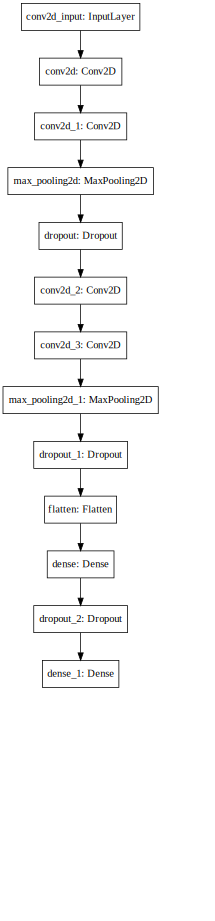

In [14]:
# Flow chart of the model 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Training The Model



In [15]:
#compiling model with loss, opt, metrics
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate=0.0009,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

model.compile(loss = loss, optimizer = opt, metrics = metrics)

In [16]:
# fitting the model for training dataset
hist = model.fit(x_train, y_train_one_hot, batch_size = 64 , epochs = 100, validation_split = 0.2)


Epoch 1/100
625/625 [==============================] - 4s 7ms/step - loss: 1.8158 - accuracy: 0.3282 - val_loss: 1.4037 - val_accuracy: 0.5000
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.3805 - accuracy: 0.5022 - val_loss: 1.1400 - val_accuracy: 0.5926
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2268 - accuracy: 0.5600 - val_loss: 1.0431 - val_accuracy: 0.6253
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 1.1315 - accuracy: 0.5977 - val_loss: 0.9847 - val_accuracy: 0.6468
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0658 - accuracy: 0.6216 - val_loss: 0.8977 - val_accuracy: 0.6820
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0144 - accuracy: 0.6422 - val_loss: 0.8512 - val_accuracy: 0.7035
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9643 - accuracy: 0.6575 - val_loss: 0.8233 - val_accuracy: 0.7082

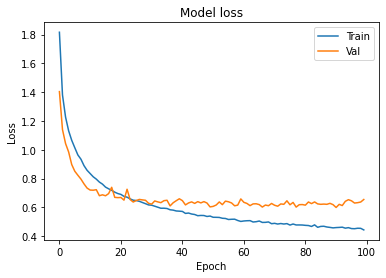

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


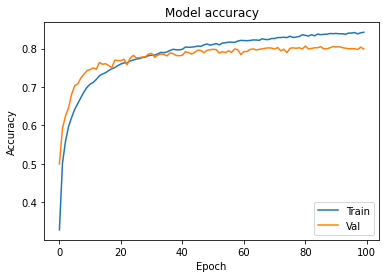

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [19]:
model.evaluate(x_test, y_test_one_hot)[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.6878 - accuracy: 0.7918


0.7918000221252441